In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# read in all the words
words = open('/content/drive/MyDrive/GitHub/makemore_names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27, 2))

In [9]:
C[5]

tensor([ 0.9253, -0.5938])

In [10]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.9253, -0.5938])

In [11]:
C[X].shape

torch.Size([228146, 3, 2])

In [12]:
X[13, 2]

tensor(1)

In [13]:
C[X][13, 2]

tensor([-2.2338,  1.1312])

In [14]:
C[1]

tensor([-2.2338,  1.1312])

In [15]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [16]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [17]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [18]:
h

tensor([[-0.6424,  1.0000,  0.9996,  ..., -0.9995, -0.3737, -0.9072],
        [-0.7456,  0.8609,  0.9960,  ...,  0.2222, -0.5182, -0.9849],
        [ 0.3069, -0.9932,  0.9433,  ...,  0.9026, -0.9945, -0.9960],
        ...,
        [ 0.9418,  0.7577,  0.9953,  ..., -0.9581,  0.9456, -0.7805],
        [ 0.7375, -0.9634,  0.9771,  ..., -0.9234,  0.7097, -0.4477],
        [-0.0488, -0.1631,  0.9727,  ...,  0.2453,  0.1952, -0.9931]])

In [19]:
h.shape

torch.Size([228146, 100])

In [20]:
(emb.view(-1, 6) @ W1).shape

torch.Size([228146, 100])

In [21]:
b1.shape

torch.Size([100])

In [22]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [23]:
logits = h @ W2 + b2

In [24]:
logits.shape

torch.Size([228146, 27])

In [25]:
counts = logits.exp()

In [26]:
prob = counts / counts.sum(1, keepdims=True)

In [27]:
prob.shape

torch.Size([228146, 27])

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

In [29]:
# cleanup

In [30]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [31]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [32]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [33]:
for p in parameters:
  p.requires_grad = True

In [34]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [49]:
lri = []
lossi = []
stepi = []

for i in range(30000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  lossi.append(loss.item())
  stepi.append(i)

# print(loss.item())

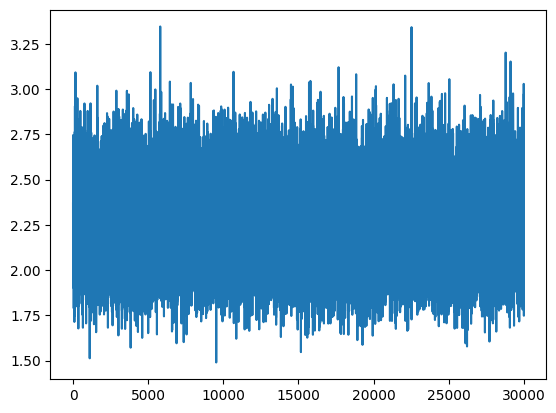

In [50]:
plt.plot(stepi, lossi)

In [51]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [52]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2592, grad_fn=<NllLossBackward0>)

In [53]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2678, grad_fn=<NllLossBackward0>)

In [54]:
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2647, grad_fn=<NllLossBackward0>)

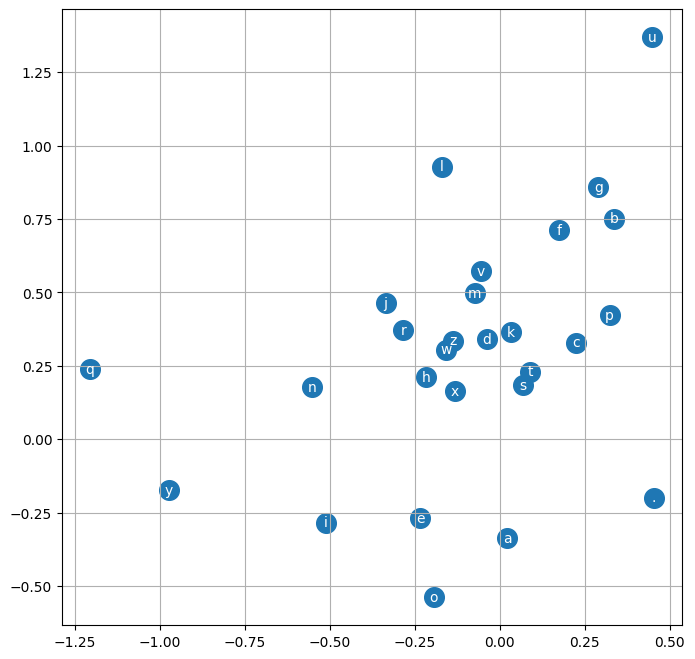

In [55]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')